In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import kstest
from scipy.stats import powerlaw
import pickle
from SALib.analyze import sobol
from itertools import combinations

## Plots of the sensitivity analysis (SOBOL)


In [27]:
data = pd.read_csv('data/sobol_results.csv')

In [28]:
problem = {
    'num_vars': 5,
    'names': ['num_buildings', 'num_destinations', 'trace_strength', 'agent_vision_angle', 'agent_vision_samples'],
    'bounds': [[50,100], [3,10], [10,100], [7.5,90], [3,15]]
    # 'bounds': [[50,100,2], [2,10,2], [10,100,2], [7.5,90,2], [3,15,2]]
}

In [29]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')
    plt.savefig('figures/sobol'+i+'.png')

In [30]:
Si_sheep = sobol.analyze(problem, data['Avg_raster_value'].values, print_to_console=True)

                            ST   ST_conf
num_buildings         1.264226  0.144624
num_destinations      0.425614  0.070924
trace_strength        0.628420  0.093679
agent_vision_angle    0.780862  0.129395
agent_vision_samples  0.552361  0.085868
                            S1   S1_conf
num_buildings         0.375049  0.215108
num_destinations     -0.123005  0.130809
trace_strength        0.043548  0.170065
agent_vision_angle    0.192991  0.172606
agent_vision_samples -0.243434  0.147536
                                                  S2   S2_conf
(num_buildings, num_destinations)          -0.116982  0.216700
(num_buildings, trace_strength)            -0.024667  0.222363
(num_buildings, agent_vision_angle)        -0.513360  0.287783
(num_buildings, agent_vision_samples)      -0.322867  0.220414
(num_destinations, trace_strength)          0.256305  0.079853
(num_destinations, agent_vision_angle)      0.317660  0.147695
(num_destinations, agent_vision_samples)    0.382131  0.187108
(tra

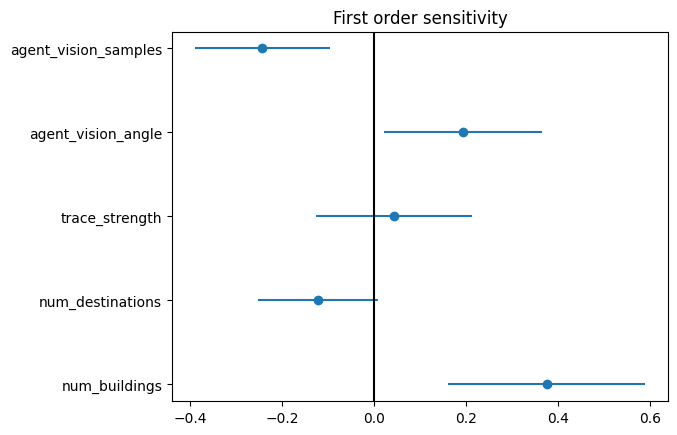

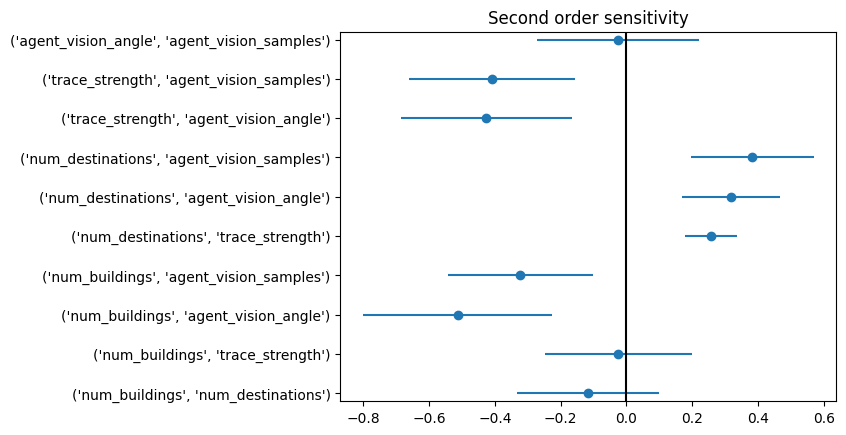

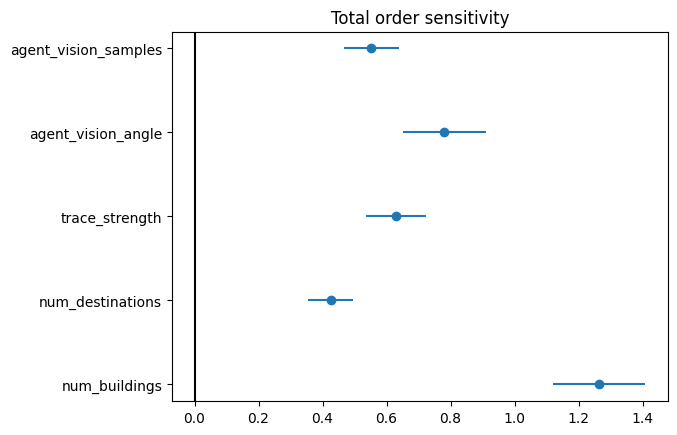

In [31]:
# First order
plot_index(Si_sheep, problem['names'], '1', 'First order sensitivity')
plt.show()

# Second order
plot_index(Si_sheep, problem['names'], '2', 'Second order sensitivity')
plt.show()

# Total order
plot_index(Si_sheep, problem['names'], 'T', 'Total order sensitivity')
plt.show()

## OFAT analysis

In [32]:
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, c='k')
    ax.fill_between(x, y - err, y + err, alpha=0.8)

    ax.set_xlabel(var.replace('_', ' ').title())
    ax.set_ylabel('Mean raster value')

def plot_all_vars(df, param):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    f, axs = plt.subplots(5, figsize=(7, 10), sharex=False)
    f.tight_layout()
    
    for i, var in enumerate(problem['names']):
        df_temp = df[~df[var].isna()]
        plot_param_var_conf(axs[i], df_temp, var, param, i)

In [33]:
problem = {
    'num_vars': 5,
    'names': ['num_buildings', 'num_destinations', 'trace_strength', 'agent_vision_angle', 'agent_vision_samples'],
    'bounds': [[50,100,11], [2,10,9], [10,100,10], [7.5,90,12], [3,15,7]]
    # 'bounds': [[50,100,2], [2,10,2], [10,100,2], [7.5,90,2], [3,15,2]]
}

In [34]:
data = pd.read_csv('data/OFAT_data.csv')

plt.style.use('seaborn-v0_8-dark-palette')

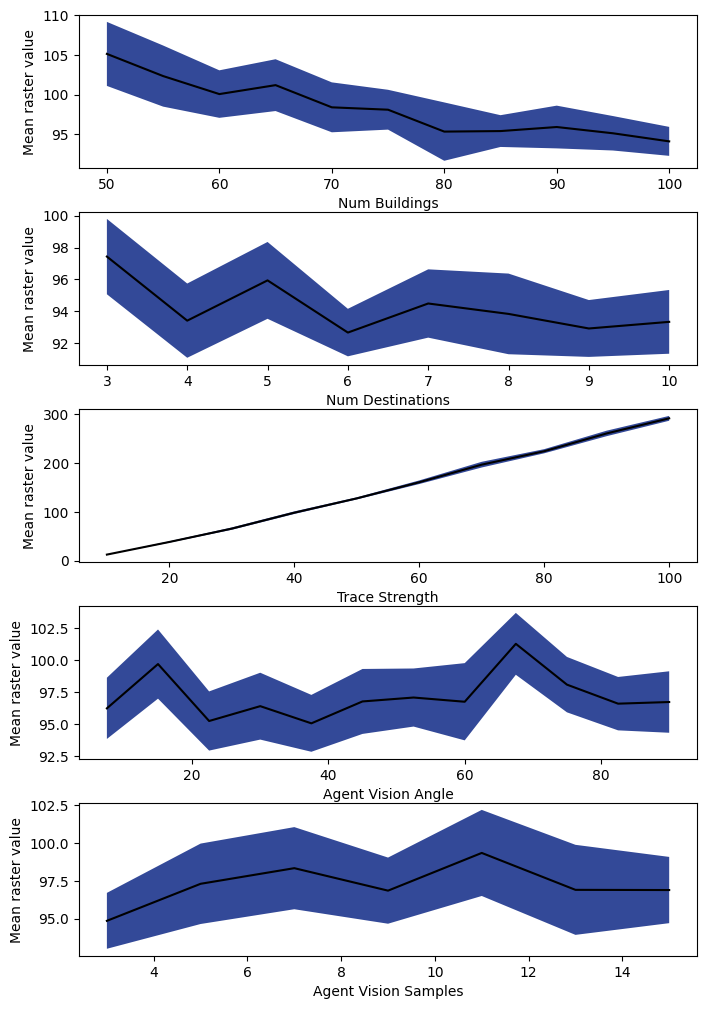

In [35]:
plot_all_vars(data, 'Avg_raster_value')
plt.savefig('figures/OFAT_plot.png', bbox_inches='tight')

## Plots and evaluation of degree distribution

In [36]:
df = pd.read_csv('data/degree_distributions_normalized2.csv', index_col=0, header=0)
plt.style.use('default')

In [37]:
# calculate mean standard deviation of all normalized degree distributions.
mean = df.iloc[:, 2:9].mean().T.values
std = df.iloc[:, 2:9].std().T.values
x = df.iloc[:, 2:9].T.index

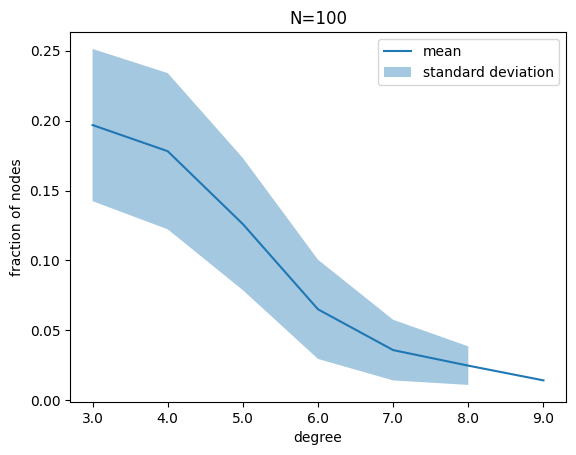

In [38]:
# plot mean standard deviation of all normalized degree distributions.
plt.plot(x, mean, label='mean')
plt.fill_between(x, (mean+std), (mean-std), alpha = 0.4, label='standard deviation')

plt.xlabel('degree')
plt.ylabel('fraction of nodes')
plt.title('N='+str(len(df)))
plt.legend()
plt.savefig('figures/degree_distributions.png', bbox_inches='tight')
# plt.xscale('log')
# plt.yscale('log')

In [39]:
# load unnormalized degree distributions
df = pd.read_csv('data/degree_distributions2.csv', index_col=0, header=0)

In [40]:
def power_law(b, epsilon, alpha):
    """powerlaw function for fitting"""
    return alpha * b**epsilon

In [41]:
# run Kolmogorov-Smirnov test on degree distributions vs. fitted powerlaw
kstest_results = pd.DataFrame(index=range(len(df)), columns=['alpha', 'epsilon', 'ks_statistic', 'ks_pvalue'])

for i in range(len(df)):
    observed = df.iloc[i].values
    #index = df.iloc[i].index
    index = [1,2,3,4,5,6,7,8,9]

    observed_filtered = []
    index_filtered = []
    for j in range(len(observed)):
        if not np.isnan(observed[j]):
            observed_filtered.append(observed[j])
            index_filtered.append(index[j])

    if len(observed_filtered) >= 5:
        fit, _ = curve_fit(power_law, index_filtered, observed_filtered)
 
        kstest_results.loc[i, ['epsilon', 'alpha']] = fit
        power = power_law(index_filtered, fit[0], fit[1])

        #power = power * sum(mean)/sum(power)


        #a = powerlaw.fit(degree_sequences[i])
        #kstest_results.loc[i, 'a'] = a


        sta, p = kstest(observed_filtered, power)
        kstest_results.loc[i, ['ks_statistic', 'ks_pvalue']] = kstest(observed_filtered, power)
    else:
        kstest_results.loc[i, ['ks_statistic', 'ks_pvalue']] = np.nan, np.nan

In [42]:
kstest_results.to_csv('data/kstest_results2.csv')
kstest_results.head()

,alpha,epsilon,ks_statistic,ks_pvalue
0,NaN,NaN,NaN,NaN
1,21.434215,-0.448434,0.333333,0.930736
2,7.299218,-0.297496,0.428571,0.575175
3,17.178654,-0.392535,0.285714,0.962704
4,18.289547,-0.433433,0.285714,0.962704


In [43]:
k_test_data = pd.read_csv('data/kstest_results2.csv')
k_test_data.drop(index=k_test_data.index[0], axis=0, inplace=True)
k_test_data.drop(columns=['Unnamed: 0'])

,alpha,epsilon,ks_statistic,ks_pvalue
1,21.434215,-0.448434,0.333333,0.930736
2,7.299218,-0.297496,0.428571,0.575175
3,17.178654,-0.392535,0.285714,0.962704
4,18.289547,-0.433433,0.285714,0.962704
5,7.020528,-0.470279,0.285714,0.962704
...,...,...,...,...
95,5.668475,-0.464656,0.428571,0.575175
96,16.318693,-0.292230,0.333333,0.930736
97,20.097493,-0.421400,0.333333,0.930736
98,6.675125,-0.242627,0.500000,0.474026


In [44]:
# count for how many of our samples we cannot reject the hypothesis that the degree distribution follows a powerlaw, i.e. the network is scale_free
significant = 0
total = 0

for p in k_test_data['ks_pvalue']:
    if not np.isnan(p):
        total += 1
        if p > 0.05:
            significant += 1

print('total number of runs considered:', total)
print('significant runs:', significant)

total number of runs considered: 96
significant runs: 96


## Comparison of betweenness centrality to metro networks
In this section we plot the average betweenness centrality against the number of nodes in the network and compare it to data from real metro networks (Derrible, 2012).

In [45]:
def mean_central(degree_centrality = dict):
    values = degree_centrality.values()
    N = len(values)
    if N == 0:
        return None, 0
    mean = 0
    for value in values:
        mean += value
    mean = mean/N

    return mean, N


In [46]:
with open('data/betweenness_centrality.pickle', 'rb') as handle:
    degree_centralities = pickle.load(handle)

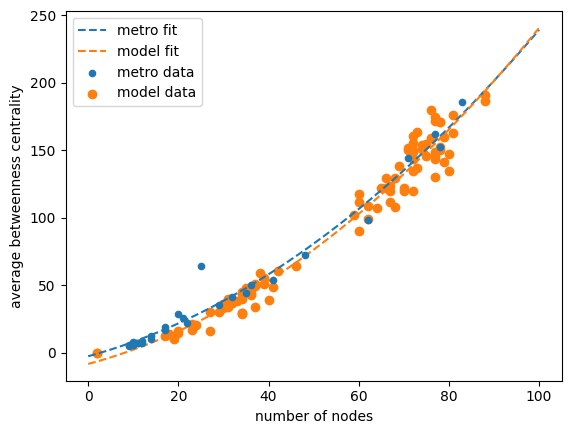

In [47]:
N = np.linspace(0,100,100)
c_data = 0.015*N**2+0.92*N-2.65 # from Derrible, 2012
city_data = pd.read_csv('data/city_data.csv', header=0)

fig, ax = plt.subplots()

Ns = []
means = []
maxs = []
mins = []
for degree_centrality in degree_centralities:
    mean, n = mean_central(degree_centrality)
    if not mean == None:
        Ns.append(n)
        means.append(mean)

plt.plot(N,c_data, label = 'metro fit', ls = '--')

fit = np.polyfit(Ns, means, 2)
c_model = fit[0]*N**2+fit[1]*N+fit[2]
plt.plot(N, c_model, label = 'model fit', ls = '--')

city_data.plot.scatter(x='Nodes',y='CB Ave', ax = ax, label = 'metro data', zorder = 10)

plt.scatter(Ns, means, c='C1', label = 'model data')

plt.xlabel('number of nodes')
plt.ylabel('average betweenness centrality')
plt.legend()
plt.savefig('figures/model_compare.png', dpi = 300)